# XGBoost to predict discharge disability: Do we have enough data?
Learning curves: How much data do we need? Do we have enough?

## Plain English summary
One simple method to see whether we have enough data is to examine how accuracy increases with training set size. Does accuracy plateau before we hit the limit to how much data we have? In that case, getting more data will not help the model significantly. Is accuracy still increasing as we reach the limit to our data size? If so we would likely benefit from more data, if we can get it.

We will wrap the model in a loop to increase the training set data size (taking a different random training/test split each time, and keeping the test set the same size). We will have an inner loop to perform 10 replicates at each sample size (to reduce the variation in our results)

## Model and data
Model: XGBoost classifier (multiclass classification) [from notebook 010]\
Target feature: Discharge disability\
Input features: All the relevant features in SSNAP\
Number of instances: different sizes of training data\
Kfold split: First kfold split

We will go through the following steps:

* Download and save pre-processed data
* Split data into features (X) and label (y)
* Split data into training and test sets (we will test on data that has not been used to fit the model)
* Standardise data
* Loop with increasing training set size:
    * Loop through 10 replicates
        * Fit a logistic regression model (from sklearn)
        * Predict survival of the test set
* Plot the relationship between training set size and accuracy

## Aims
Do we have enough data?

## Observations
It appears that we need all, if not more, data to obtain the best accuracy.

## Further work
Look at feature selection, see notebook 020.

## Load modules

A standard Anaconda install of Python (https://www.anaconda.com/distribution/) contains all the necessary modules.

In [1]:
# Import machine learning methods
from sklearn.model_selection import train_test_split

# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline

from xgboost import XGBClassifier
from sklearn.metrics import auc

from dataclasses import dataclass

from sklearn.metrics import roc_auc_score

import time
import datetime

Report the time duration to run notebook

In [2]:
start_time = time.time()

## Set up paths and filenames

In [3]:
@dataclass(frozen=True)
class Paths:
    '''Singleton object for storing paths to data and database.'''
    image_save_path: str = './saved_images'
    model_save_path: str = './saved_models'
    data_save_path: str = './saved_data'
    data_read_path: str = '../data_processing/output'
    model_text: str = f'xgb_all_features_learning_curve'
    notebook: str = '015_'

paths = Paths()

## Load data

In [4]:
filename = os.path.join(paths.data_read_path, '02_reformatted_data_ml.csv')
data = pd.read_csv(filename)

Some features need to be removed from the dataset (those that are duplicates). Define a function to do this.

In [5]:
def drop_columns(df, cols):
    """
    For the dataframe, remove the columns 'cols' if they are present
    
    Args:
        df [dataframe]: The feature values per patient
        cols [list]: The features to remove if present

    Return:
        df [dataframe]: The feature values per patient without specified columns
    """
    for col in cols:
        if col in df.columns: df.drop([col],axis=1,inplace=True)
    return(df)

Remove columns

In [6]:
cols_remove = ['id','stroke_team_id']
data = drop_columns(data, cols_remove)
feature_names = list(data)
# number of dependant features
n_features = len(feature_names) - 1

Store the output classes

In [7]:
class_names = data['discharge_disability'].unique()
class_names = np.sort(class_names)
n_classes = len(class_names)
print(f'There are {n_classes} target categories')

There are 7 target categories


## Divide into X (features) and y (labels)

We will separate out our features (the data we use to make a prediction) from our label (what we are truing to predict).
By convention our features are called `X` (usually upper case to denote multiple features), and the label (survive or not) `y`.

In [8]:
# Get X and y
X = data.drop('discharge_disability', axis=1)
y = data['discharge_disability']

## One hot the categorical features

Convert some categorical features to one hot encoded features.

Define a function

In [9]:
def convert_feature_to_one_hot(df, feature_name, prefix):
    """
    Converts a categorical feature into a one hot encoded feature
    
    Args:
        df [dataframe]: training or test dataset
        feature_name [str]: feature to convert to one hot encoding
        prefix [str]: string to use on new feature

    Return:
        df [dataframe]: One hot encoded representation of the feature
    """

    # One hot encode a feature
    df_feature = pd.get_dummies(
        df[feature_name], prefix = prefix)
    df = pd.concat([df, df_feature], axis=1)
    df.drop(feature_name, axis=1, inplace=True)

    return(df)

Set up two lists for the one hot encoding. 

A list of the feature names that are categorical and to be converted using one hot encoding.
A list of the prefixes to use for these features.

In [10]:
features_to_one_hot = ["stroke_team", "weekday"]
list_prefix = ["team", "weekday"]

For each feature in the list, fconvert to one hot encoded.

In [11]:
for feature, prefix in zip(features_to_one_hot, list_prefix):
    X = convert_feature_to_one_hot(X, feature, prefix)

Feature names with one hot encoding

In [12]:
features_ohe = list(X)
n_features_ohe = len(features_ohe)

In [13]:
print(f"There are {n_features} original features "
      f"(before one-hot encoding)")
print(f"There are {n_features_ohe} features (after one-hot encoding)")

There are 54 original features (before one-hot encoding)
There are 177 features (after one-hot encoding)


## Calculate the maximum training set size we can use 
We will use 25% of data for testing

In [14]:
test_fraction = 0.25
data_rows = X.shape[0]
max_training_size = int(data_rows * (1 - test_fraction))
print('Max training size: {}'.format(max_training_size))

Max training size: 126260


## Train XGBoost models
Loop through increasing training set sizes 

In [15]:
# Set up list to collect results
results_training_size = []
results_roc_auc_ovr = []

for train_size in range(1000, max_training_size, 1000):
    replicate_roc_auc_ovr = []
    for replicate in range(10):
        y_train = np.array([])
        # Keep spliting until get one of each category in the training set
        while len(np.unique(y_train))!=n_classes:
            # Split data into training and test
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size = test_fraction)

            # Reduce training set size (use np random choice for random index values)
            selection_index = np.random.choice(
                max_training_size, train_size, replace=False)
            X_train = X_train.iloc[selection_index]
            y_train = y_train.iloc[selection_index]

        # Define model
        model = XGBClassifier(verbosity=0, seed=42, learning_rate=0.5)

        # Fit model
        model.fit(X_train, y_train)

        # Get target categories from model
        classes = model.classes_

        # Get predicted probabilities
        y_probs = model.predict_proba(X_test)

        # Calculate ROC AUC for multiclass models, using One vs Rest
        roc_auc_ovr = roc_auc_score(y_test, y_probs, labels = classes, 
                                    multi_class = 'ovr', average = 'macro')

        # Record results
        replicate_roc_auc_ovr.append(roc_auc_ovr)

    results_roc_auc_ovr.append(np.mean(replicate_roc_auc_ovr))
    results_training_size.append(train_size)

## Plot learning curve

We will plot the learning curve, including a moving average (the mean of 5 points). Moving averages can help show trends when data is noisy.

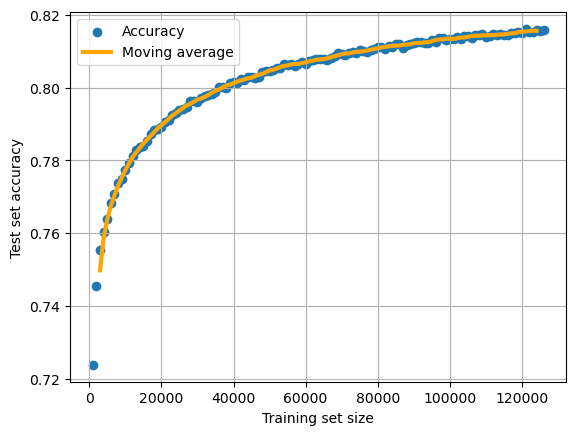

In [16]:
# Calculate moving average (of last 5 points) with np.convolve
moving_average = np.convolve(results_roc_auc_ovr, np.ones((5,))/5, mode='valid')
# Include an offset to centre mean
x_moving_average = results_training_size[2:-2]

plt.scatter(results_training_size, results_roc_auc_ovr, 
         label='Accuracy')

plt.plot(x_moving_average, moving_average,
        label='Moving average',
        color='orange',
        linewidth=3)

plt.xlabel('Training set size')
plt.ylabel('Test set accuracy')
plt.legend()
plt.grid(True)

filename = os.path.join(paths.image_save_path, 
                        (paths.notebook + paths.model_text + 
                         '_learning_curve.jpg'))
plt.savefig(filename, dpi=300)

plt.show()

It appears that we need all, if not more, data to obtain the best accuracy.

In [17]:
end_time = time.time()

print(f'Time taken: {end_time - start_time}')

Time taken: 23061.65219926834
